<a href="https://colab.research.google.com/github/gtsagkatakis/Data-Science-and-Applications/blob/main/CSD458_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 3: Classifying Wines with Support Vector Machines (SVM)

The objective of this exercise is to build and evaluate a Support Vector Machine (SVM) model for classifying wines based on their chemical properties using the Wine dataset available in scikit-learn. You will explore various aspects of SVM model training and optimization, including preprocessing steps, hyperparameter tuning, and kernel selection.







#Loading the Dataset

Load the Wine dataset using load_wine from sklearn.datasets.
Inspect the dataset to understand its structure and features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

df, target = load_wine(return_X_y=True, as_frame=True)

df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


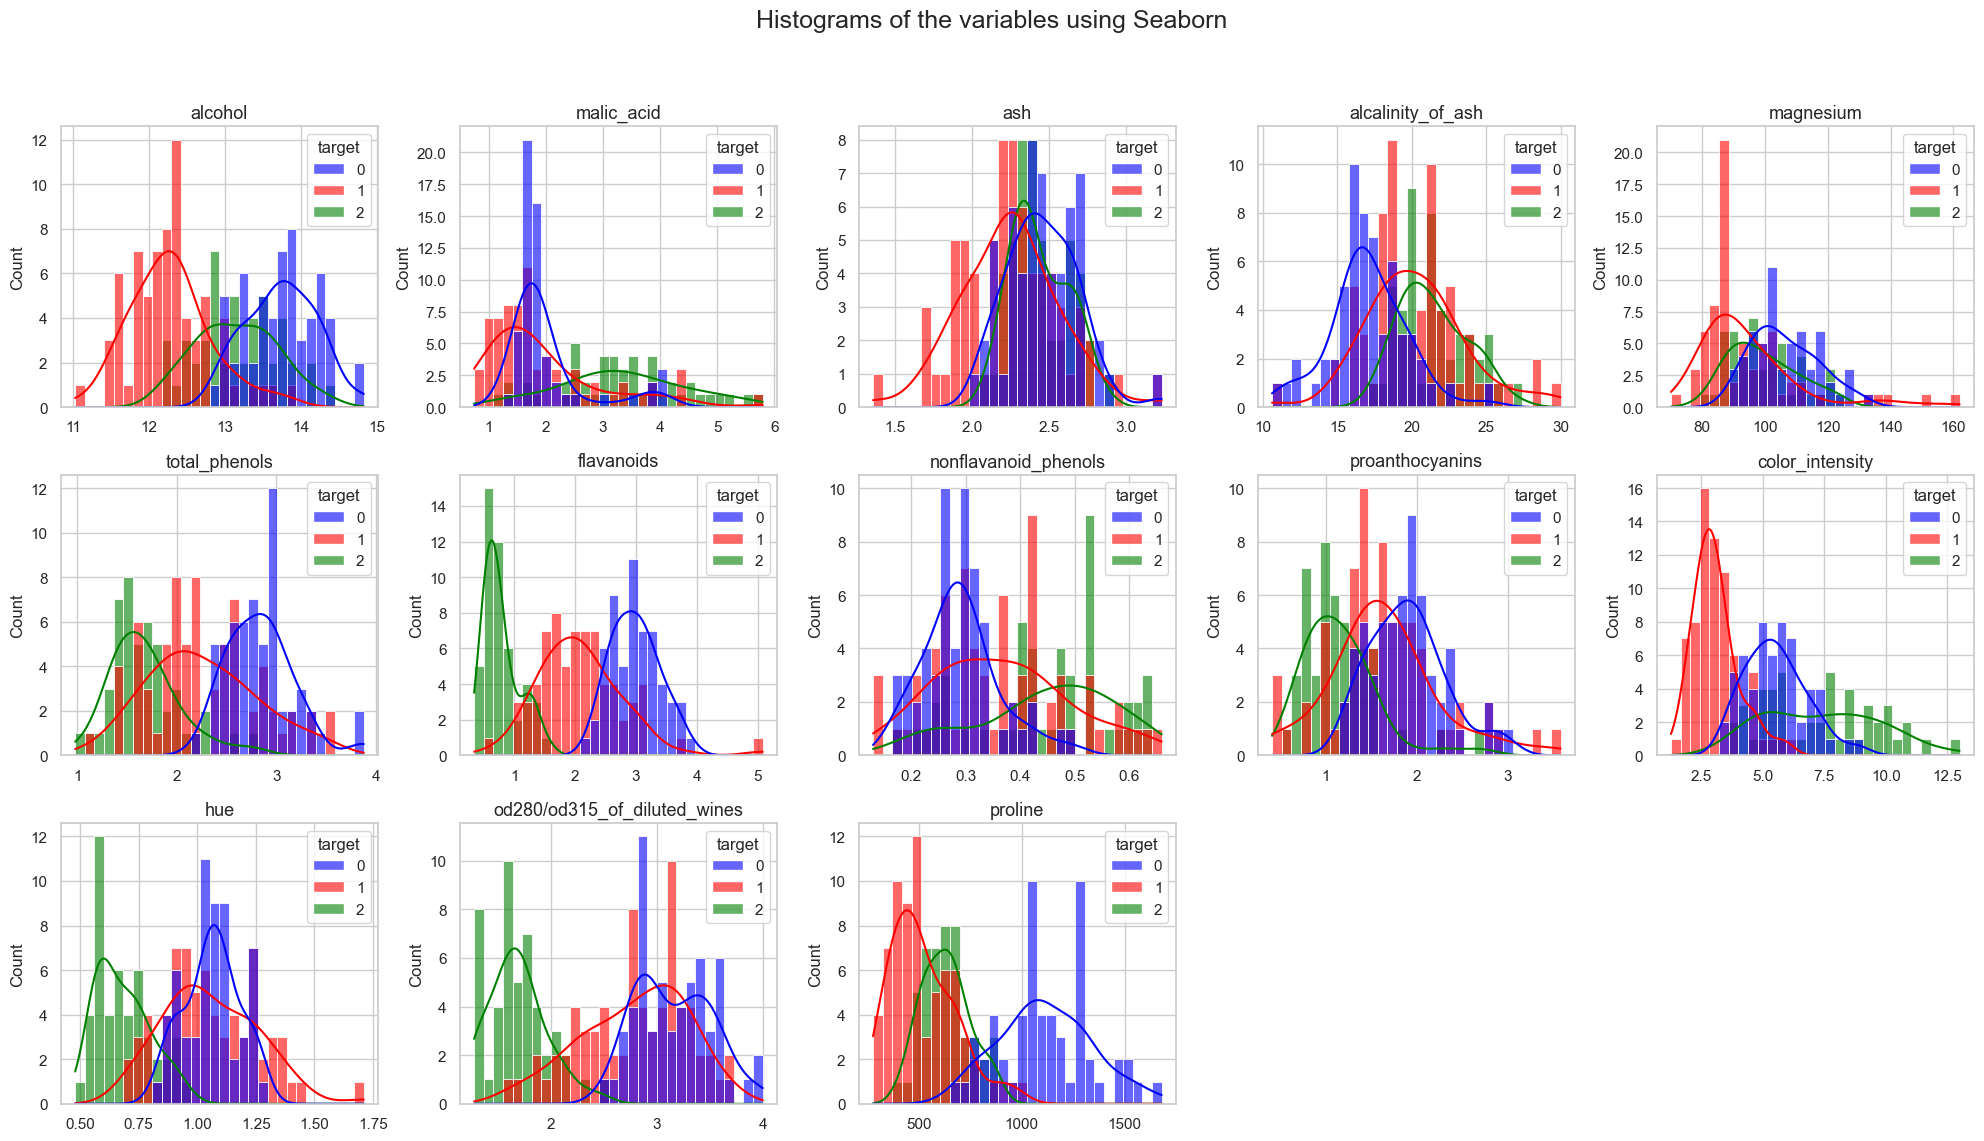

In [2]:
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Seaborn Plot
# Create a 3x5 grid of subplots (since there are 13 features)
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()  # Flatten the array for easy iteration

# Define the colors for each class
colors = ['blue', 'red', 'green']

# Plot histograms using Seaborn
for i, ax in enumerate(axes):
    if i < len(df.columns):
        sns.histplot(df, x=df.columns[i], hue=target, palette=colors, ax=ax, bins=30, alpha=0.6, kde=True)
        ax.set_title(df.columns[i], fontsize=13)
        ax.set_xlabel('')  # Hide x label
        
    else:
        ax.set_visible(False)  # Hide unused subplots

# Adjust the title and layout
fig.suptitle('Histograms of the variables using Seaborn', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
# Create a 3x5 subplot grid (since there are 13 features)
plotly_fig = make_subplots(rows=3, cols=5)

# Define the colors for each class
colors = ['blue', 'red', 'green']

# Get the min and max values for each feature to set the axis range
feature_ranges = {col: (df[col].min(), df[col].max()) for col in df.columns}

# Plot histograms using Plotly
for i, cls in enumerate(sorted(target.unique())):  # Ensure consistent color assignment
    for j, col in enumerate(df.columns):
        # Add only the first trace of each class to the legend
        show_legend = j == 0
        plotly_fig.add_trace(
            go.Histogram(
                x=df[col][target == cls],
                nbinsx=30,
                name=f'Class {cls}',
                marker=dict(color=colors[i]),
                opacity=0.75,
                legendgroup=f'class_{cls}',  # Set a unique legend group for each class
                showlegend=show_legend
            ),
            row=(j // 5) + 1,
            col=(j % 5) + 1
        )

# Set the titles for each subplot and adjust the range
for i, col in enumerate(df.columns):
    row, col_num = (i // 5) + 1, (i % 5) + 1
    plotly_fig.update_xaxes(title_text=col, row=row, col=col_num, range=feature_ranges[col])
    plotly_fig.update_yaxes(title_text='Count', row=row, col=col_num)

# Update layout
plotly_fig.update_layout(
    title_text='Histograms of the variables using Plotly',
    title_x=0.5,
    legend_title_text='Class',
    barmode='overlay',
    bargap=0.1,
    height=800  # Adjust the height to fit all subplots neatly
)

# Hide the empty subplots
for i in range(len(df.columns), 15):
    row, col = (i // 5) + 1, (i % 5) + 1
    plotly_fig.update_xaxes(visible=False, row=row, col=col)
    plotly_fig.update_yaxes(visible=False, row=row, col=col)

# Save the plot
plotly_fig.write_html("plotly_histograms.html")

# Show the Plotly interactive plot
plotly_fig.show(config={'displayModeBar': False})  # Hide the modebar by default

#Data Preprocessing

- Split the dataset into features and target labels.
- Split the data into training and testing sets using train_test_split from sklearn.model_selection.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((124, 13), (54, 13), (124,), (54,))

# Baseline Model

Train a baseline SVM model using default hyperparameters.
Evaluate the model's performance on the testing set using metrics like accuracy, precision, recall, and F1-score. Experiment with different kernel functions (e.g., linear, polynomial, RBF) and observe their effects on model performance.

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_linear = SVC()

svm_linear.fit(X_train, y_train)

y_pred = svm_linear.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.63      0.90      0.75        21
           2       0.60      0.21      0.32        14

    accuracy                           0.76        54
   macro avg       0.74      0.71      0.69        54
weighted avg       0.75      0.76      0.72        54


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_linear.fit(X_train_scaled, y_train)

y_pred = svm_linear.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.96        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54


#Data Normalization

Standardize the features using StandardScaler from sklearn.preprocessing.
Explore the effects of data normalization on model performance with different normalization techniques.

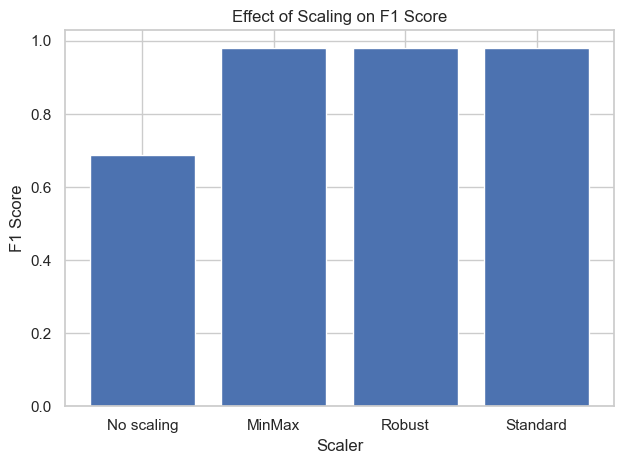

In [12]:
# import scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import f1_score

# create a dummy scaler that does nothing
class DummyScaler:
    
    def fit(self, X):
        pass
    def transform(self, X):
        return X
    def fit_transform(self, X):
        return X


# init the scalers
scalers = [DummyScaler(), MinMaxScaler(), RobustScaler(), StandardScaler()]

# init a model
svm = SVC()

# arrays to store the results
train_scores = []

# loop through the scalers
for scaler in scalers:
    # scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # fit the model
    svm.fit(X_train_scaled, y_train)
    
    # predict
    y_pred = svm.predict(X_test_scaled)
    
    # score
    train_scores.append(f1_score(y_test, y_pred, average='macro'))
    
# plot the results
plt.bar(['No scaling', 'MinMax', 'Robust', 'Standard'], train_scores)
plt.xlabel('Scaler')
plt.ylabel('F1 Score')
plt.title('Effect of Scaling on F1 Score')

plt.tight_layout()
plt.show()

#Hyperparameter Tuning

Perform hyperparameter tuning to find the best combination of hyperparameters for the SVM model.
Tune hyperparameters such as C (regularization parameter) and the choice of kernel (linear, polynomial, RBF).
Use techniques like GridSearchCV or RandomizedSearchCV from sklearn.model_selection to efficiently search through the hyperparameter space.

In [13]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Initialize the scorer
scorer = make_scorer(f1_score, average='macro')

# Define the base pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(cache_size=1000))])

# Define a separate param grid for each kernel
param_grids = {
    'linear': {'svc__kernel': ['linear'], 'svc__C': [1, 5, 10], 'svc__gamma': ['scale', 'auto'], 'svc__shrinking': [True, False]},
    'poly': {'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4], 'svc__C': [1, 5, 10], 'svc__shrinking': [True, False]},
    'rbf': {'svc__kernel': ['rbf'], 'svc__gamma': ['scale', 'auto'], 'svc__C': [1, 5, 10], 'svc__shrinking': [True, False]},
    'sigmoid': {'svc__kernel': ['sigmoid'], 'svc__gamma': ['scale', 'auto'], 'svc__C': [1, 5, 10], 'svc__shrinking': [True, False]}
}

# Dictionary to store the best estimator for each kernel
best_estimators = {}

# Perform a grid search for each kernel
for kernel in param_grids:
    print(f"Starting grid search for {kernel} kernel...")
    SVC_CV = GridSearchCV(pipe, param_grids[kernel], cv=10, scoring=scorer, n_jobs=-1, verbose=True)
    SVC_CV.fit(X_train, y_train)
    best_estimators[kernel] = SVC_CV.best_estimator_
    print(f"Best CV score for {kernel} kernel = {SVC_CV.best_score_:.3f}")
    print(f"Best parameters for {kernel} kernel: {SVC_CV.best_params_}\n")


Starting grid search for linear kernel...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best CV score for linear kernel = 0.984
Best parameters for linear kernel: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__shrinking': True}

Starting grid search for poly kernel...
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best CV score for poly kernel = 0.958
Best parameters for poly kernel: {'svc__C': 5, 'svc__degree': 3, 'svc__kernel': 'poly', 'svc__shrinking': True}

Starting grid search for rbf kernel...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best CV score for rbf kernel = 0.974
Best parameters for rbf kernel: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__shrinking': True}

Starting grid search for sigmoid kernel...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best CV score for sigmoid kernel = 0.976
Best parameters for sigmoid kernel: {'svc__C': 1, 'svc__gamma': 'scale', 'svc

#Effects of Data Size

Explore the effects of varying the size of the training data on model performance.
Train SVM models using different proportions of the training data (change the number of CV folds) and observe how performance changes. Visualize the relationship between training size and model performance.

In [15]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define the training sizes / CV folds
folds = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Dictionary to store the best parameters for each kernel from GridSearchCV
best_params = {
    'linear': {'kernel': 'linear', 'C': 1, 'gamma': 'scale', 'shrinking': True},
    'poly': {'kernel': 'poly', 'C': 5, 'degree': 3, 'shrinking': True},
    'rbf': {'kernel': 'rbf', 'C': 1, 'gamma': 'scale', 'shrinking': True},
    'sigmoid': {'kernel': 'sigmoid', 'C': 1, 'gamma': 'scale', 'shrinking': True}
}

# Initialize the results dictionary
results = {kernel: [] for kernel in best_params}

# Loop through each kernel and perform cross-validation
for kernel, params in best_params.items():
    # Initialize the model with the best parameters
    svm = SVC(**params, cache_size=1000)

    # Define the pipeline
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svc', svm)])
    
    print(f"Starting cross-validation for {kernel} kernel...")
    
    # Loop through the folds
    for fold in folds:
        scores = cross_val_score(pipe, X_train, y_train, cv=fold, scoring=scorer, n_jobs=-1)
        results[kernel].append(scores.mean())


Starting cross-validation for linear kernel...
Starting cross-validation for poly kernel...
Starting cross-validation for rbf kernel...
Starting cross-validation for sigmoid kernel...


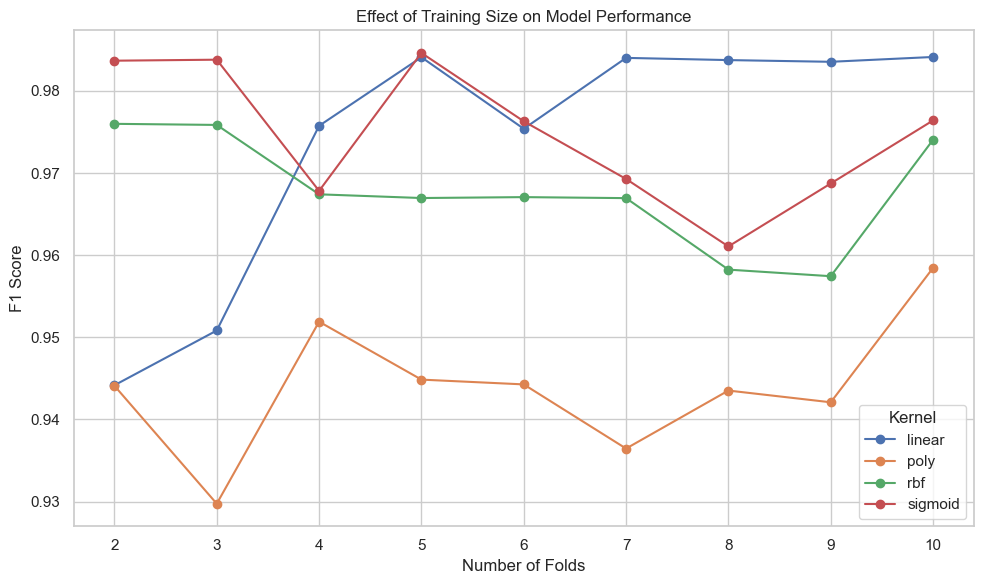

In [20]:
# have 1 plot for all kernels
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the results
for kernel, scores in results.items():
    ax.plot(folds, scores, marker='o', label=kernel)
    
# Add labels and title
ax.set_xlabel('Number of Folds')
ax.set_ylabel('F1 Score')
ax.set_title('Effect of Training Size on Model Performance')
ax.legend(title='Kernel', loc='best')

plt.tight_layout()
plt.show()

# Model Evaluation

Evaluate the final tuned SVM model on the testing set using various performance metrics.
Plot confusion matrices to visualize the model's predictions.
Discuss the results and insights gained from the experimentation.

In [17]:
# import scoring functions
from sklearn.metrics import classification_report, confusion_matrix

# Now, for each kernel's best estimator, predict on the test set and evaluate performance
test_scores = {}
for kernel, estimator in best_estimators.items():
    y_pred = estimator.predict(X_test)
    
    test_scores[kernel] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"Test scores for {kernel} kernel:")
    print(f"Classification Report:\n{test_scores[kernel]['classification_report']}")
    print(f"Confusion Matrix:\n{test_scores[kernel]['confusion_matrix']}\n")
    print("------------------------------------------------------\n")

Test scores for linear kernel:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:
[[19  0  0]
 [ 0 20  1]
 [ 0  0 14]]

------------------------------------------------------

Test scores for poly kernel:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:
[[

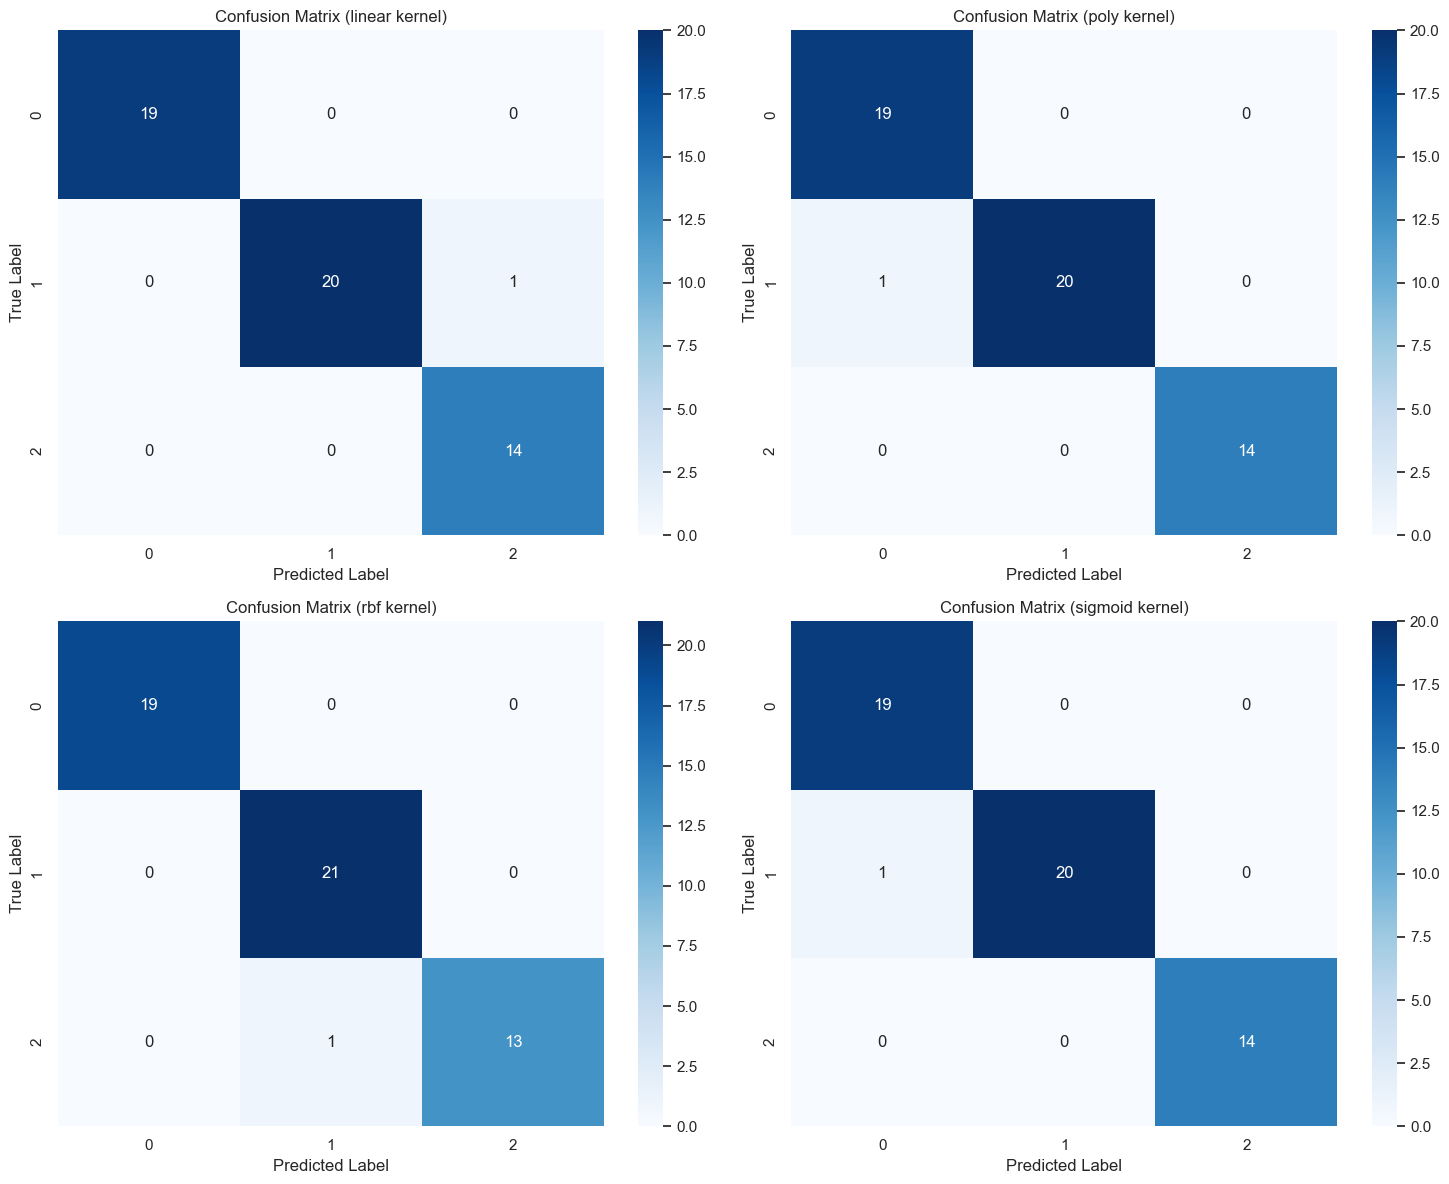

In [22]:
# Plot the confusion matrices for each kernel's best estimator
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, (kernel, scores) in enumerate(test_scores.items()):
    row, col = i // 2, i % 2
    sns.heatmap(scores['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f'Confusion Matrix ({kernel} kernel)')
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_ylabel('True Label')
    
plt.tight_layout()
plt.show()

# Discussion

The SVM model was trained and evaluated on the Wine dataset, which contains 13 features related to the chemical properties of different wines. The dataset was split into training and testing sets, and a baseline SVM model was trained using the default hyperparameters. The model's performance was evaluated using metrics such as accuracy, precision, recall, and F1-score. The effects of data normalization and hyperparameter tuning were explored, and the final tuned SVM model was evaluated on the testing set.

We observe that for any kernel, after some basic hyperparameter tuning, the model performs well on the test set. The F1 score is high for all kernels, and the confusion matrices show that the model is able to accurately classify the wine samples into their respective classes. This indicates that the SVM model is able to effectively learn the decision boundaries between the different classes of wines based on their chemical properties. The choice of kernel does not seem to have a significant impact on the model's performance, as all kernels perform similarly well on the test set.